First 5 rows:
   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0            5.1           3.5            1.4           0.2  Iris-setosa
1            4.9           3.0            1.4           0.2  Iris-setosa
2            4.7           3.2            1.3           0.2  Iris-setosa
3            4.6           3.1            1.5           0.2  Iris-setosa
4            5.0           3.6            1.4           0.2  Iris-setosa

Shape: (150, 5)

Class mapping: {'Iris-setosa': np.int64(0), 'Iris-versicolor': np.int64(1), 'Iris-virginica': np.int64(2)}

Train shape: (120, 4) Test shape: (30, 4)

Baseline KNN Accuracy: 0.9333

Baseline Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.83      1.00      0.91        10
 Iris-virginica       1.00      0.80      0.89        10

       accuracy                           0.93        30
      macro avg       0.94   

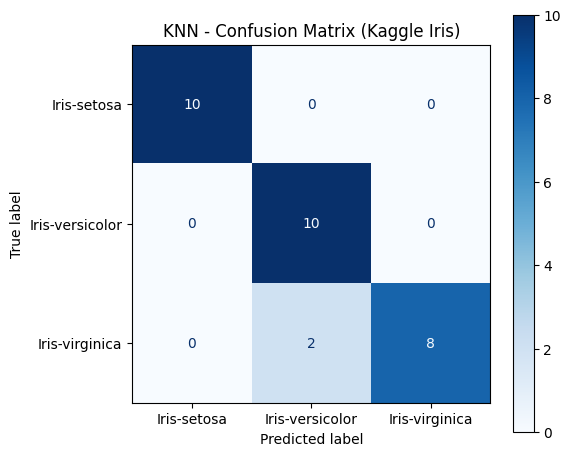

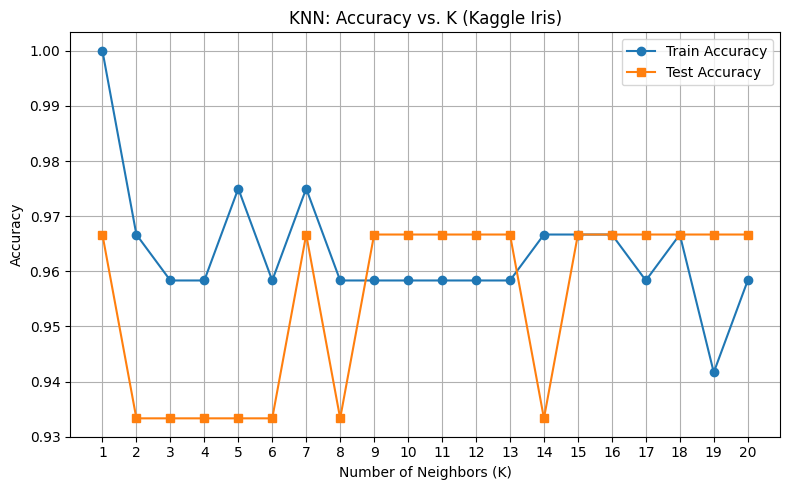

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay)

import matplotlib.pyplot as plt

# ----------------------------
# 1. Data Collection
# ----------------------------

df = pd.read_csv('Iris.csv')

print("First 5 rows:")
print(df.head())
print("\nShape:", df.shape)

# ----------------------------
# 2. Data Preprocessing
# ----------------------------

if 'Id' in df.columns:
    df.drop(columns=['Id'], inplace=True)

feature_cols = ['SepalLengthCm', 'SepalWidthCm',
                'PetalLengthCm', 'PetalWidthCm']

X = df[feature_cols]
y = df['Species']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("\nClass mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# ----------------------------
# 3. Train–Test Split
# ----------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)

# ----------------------------
# 4. Feature Scaling
# ----------------------------

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------------------
# 5. Baseline KNN Model
# ----------------------------

knn_base = KNeighborsClassifier()
knn_base.fit(X_train_scaled, y_train)

y_pred_base = knn_base.predict(X_test_scaled)
base_acc = accuracy_score(y_test, y_pred_base)
print(f"\nBaseline KNN Accuracy: {base_acc:.4f}")

print("\nBaseline Classification Report:")
print(classification_report(y_test, y_pred_base,
                            target_names=le.classes_))

# ----------------------------
# 6. Hyperparameter Tuning with GridSearchCV
# ----------------------------

param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print("\nBest Parameters (KNN):")
print(grid_search.best_params_)
print(f"Best CV Score: {grid_search.best_score_:.4f}")

best_knn = grid_search.best_estimator_

# ----------------------------
# 7. Final Model Evaluation
# ----------------------------

y_pred = best_knn.predict(X_test_scaled)

print("\n--- Final KNN Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred,
                            target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Blues', ax=ax)
plt.title('KNN - Confusion Matrix (Kaggle Iris)')
plt.tight_layout()
plt.show()

# ----------------------------
# 8. Optional: Accuracy vs. K Plot
# ----------------------------

k_values = range(1, 21)
train_accuracies = []
test_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_accuracies.append(knn.score(X_train_scaled, y_train))
    test_accuracies.append(knn.score(X_test_scaled, y_test))

plt.figure(figsize=(8, 5))
plt.plot(k_values, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(k_values, test_accuracies, marker='s', label='Test Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.title('KNN: Accuracy vs. K (Kaggle Iris)')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
